# Multi class Random Forest modelling using size of physical guarantee bins as the class to be predicted

### Import libraries and load data

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
%matplotlib inline
import seaborn as sns
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)
print('x' in np.arange(5))   #returns False, without Warning

False


In [92]:
##Importing data and creating dataframe 
df = pd.read_csv('firstout.csv')
df.head()

,Unnamed: 0,id,plant,size,number,auction,capacity,physical_guarantee,sold_lots,source,...,gkf,fdi,primary_energy_consumption,g,exch,inv_US$_billion,state,inv_size,physical_guarantee_size,distance_from_last_auction
0,0,1,UHE Foz do Rio Claro,0.091,11,Leilão 2/2005,68.4,41.0,41.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.120104543,GO,10918594.82,3.727273,0.798005
1,1,2,UHE São José,0.091,11,Leilão 2/2005,51.0,30.4,30.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.08931406,RS,8119460.00,2.763636,0.798005
2,2,3,UHE Passo São João,0.091,11,Leilão 2/2005,77.0,39.0,37.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.114362101,RS,10396554.64,3.545455,0.798005
3,3,4,UHE Simplício,0.091,11,Leilão 2/2005,337.7,191.3,185.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.616054447,RJ,56004949.73,17.390909,0.798005
4,4,5,UHE Retiro Baixo,0.091,11,Leilão 2/2005,82.0,38.5,36.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.112149186,MG,10195380.55,3.500000,0.798005


In [93]:
#Retrieving keys
df.keys()

Index(['Unnamed: 0', 'id', 'plant', 'size', 'number', 'auction', 'capacity',
       'physical_guarantee', 'sold_lots', 'source', 'company_consortium',
       'year', 'price_US$', 'inv_US$', 'gdp_growth', 'risk_embi', 'gkf', 'fdi',
       'primary_energy_consumption', 'g', 'exch', 'inv_US$_billion', 'state',
       'inv_size', 'physical_guarantee_size', 'distance_from_last_auction'],
      dtype='object')

In [94]:
#Removing unnecessary columns from dataframe 
df = df.drop(columns=['Unnamed: 0', 'id', 'plant', 'number', 'auction', 'capacity', 'sold_lots', 'company_consortium',
       'year', 'gdp_growth', 'risk_embi', 'gkf', 'fdi', 'size', 'physical_guarantee',
       'primary_energy_consumption', 'g', 'exch', 'inv_US$_billion', 'inv_size'])
df.head()

,source,price_US$,inv_US$,state,physical_guarantee_size,distance_from_last_auction
0,hydro,46.172913,120104543.0,GO,3.727273,0.798005
1,hydro,49.489294,89314060.0,RS,2.763636,0.798005
2,hydro,48.100346,114362101.0,RS,3.545455,0.798005
3,hydro,49.309800,616054447.0,RJ,17.390909,0.798005
4,hydro,49.087568,112149186.0,MG,3.500000,0.798005


### Factorizing the non-numeric variables

In [95]:
#Factorize source
factor = pd.factorize(df['source'])
df.source = factor[0]
definitions = factor[1]
print(df.source.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: source, dtype: int64
Index(['hydro', 'coal', 'sugar cane bagasse', 'diesel oil', 'others',
       'fuel oil', 'biomass', 'natural gas', 'wind', 'solar', 'biogas'],
      dtype='object')


In [96]:
#Factorize state
factor2 = pd.factorize(df['state'])
df.state = factor2[0]
definitions2 = factor2[1]
print(df.state.head())
print(definitions2)

0    0
1    1
2    1
3    2
4    3
Name: state, dtype: int64
Index(['GO', 'RS', 'RJ', 'MG', 'SP', 'MT', 'PR', 'RN', 'BA', 'PE', 'SC', 'CE',
       'MA', 'MS', 'RO', 'PB', 'TO', 'ES', 'PI', 'AP', 'AL', 'SE', 'PA', 'AM',
       'RR', 'AC'],
      dtype='object')


In [97]:
#Control that it has worked in the data frame 
df = df.dropna()
df.head()

,source,price_US$,inv_US$,state,physical_guarantee_size,distance_from_last_auction
0,0,46.172913,120104543.0,0,3.727273,0.798005
1,0,49.489294,89314060.0,1,2.763636,0.798005
2,0,48.100346,114362101.0,1,3.545455,0.798005
3,0,49.309800,616054447.0,2,17.390909,0.798005
4,0,49.087568,112149186.0,3,3.500000,0.798005


### Creating 5 bins for size

In [98]:
size_bin = ['A', 'B', 'C', 'D', 'E']
df['physical_guarantee_size_bin'] = pd.cut(df['physical_guarantee_size'], bins=[0, 1.5, 10, 30, 100, 4571], labels=size_bin)

In [99]:
# Checked if that worked by counting values
df['physical_guarantee_size_bin'].value_counts()

A    1158
B      81
C      32
E       5
D       5
Name: physical_guarantee_size_bin, dtype: int64

In [100]:
#Control that it has worked in the data frame 
df = df.dropna()
df.head()

,source,price_US$,inv_US$,state,physical_guarantee_size,distance_from_last_auction,physical_guarantee_size_bin
0,0,46.172913,120104543.0,0,3.727273,0.798005,B
1,0,49.489294,89314060.0,1,2.763636,0.798005,B
2,0,48.100346,114362101.0,1,3.545455,0.798005,B
3,0,49.309800,616054447.0,2,17.390909,0.798005,C
4,0,49.087568,112149186.0,3,3.500000,0.798005,B


### Defining the model

In [101]:
# Dropping "price_US$" and "distance_from_last_auction"
df=df[['source', 'inv_US$', 'state', 'physical_guarantee_size_bin']]

In [102]:
#Splitting the data into independent and dependent variables
X = df.iloc[:,0:3].values
y = df.iloc[:,3].values
print('The independent features set: ')
print(X[:3,:])
print('The dependent variable: ')
print(y[:3])

The independent features set: 
[[0.00000000e+00 1.20104543e+08 0.00000000e+00]
 [0.00000000e+00 8.93140600e+07 1.00000000e+00]
 [0.00000000e+00 1.14362101e+08 1.00000000e+00]]
The dependent variable: 
['B', 'B', 'B']
Categories (5, object): ['A' < 'B' < 'C' < 'D' < 'E']


### Split the data into training and testing sets and feature scaling

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)


In [104]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Running the model using the "entropy" criterion and by tuning many variables

In [105]:
from sklearn.calibration import CalibratedClassifierCV
classifier = RandomForestClassifier(criterion = 'entropy', random_state=42, class_weight='balanced') ## with class balanced for imbalanced classification
classifier.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
cal_clf.fit(X_test, y_test)
y_score = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict_proba(X)


array([[0.        , 0.16576691, 0.39423309, 0.        , 0.44      ],
       [0.        , 0.23      , 0.21      , 0.06      , 0.5       ],
       [0.        , 0.23      , 0.21      , 0.06      , 0.5       ],
       ...,
       [0.36      , 0.1       , 0.08      , 0.11      , 0.35      ],
       [0.36      , 0.1       , 0.08      , 0.11      , 0.35      ],
       [0.36      , 0.1       , 0.08      , 0.11      , 0.35      ]])

### Obtaining predictions
***
#### Without using the "gini" criterion and with a smaller cc-alpha value, the list of probable predictions is much more mixed

In [106]:
y_pred

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'A', 'A', 'B', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A',
       'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'],
      dtype=object)

### Some steps towards analysing the result

In [107]:
#Creating a dataframe with the predicition array
df2 = pd.DataFrame(y_pred, columns = ['predicted_size'])
df2



,predicted_size
0,A
1,A
2,A
3,A
4,A
...,...
124,A
125,A
126,A
127,A


In [108]:
#Count predicted values
df2['predicted_size'].value_counts()

A    120
B      8
C      1
Name: predicted_size, dtype: int64

In [109]:
#Normalize counted values
df2.predicted_size.value_counts(normalize=True)

A    0.930233
B    0.062016
C    0.007752
Name: predicted_size, dtype: float64

### An analysis of the metrics

#### Accuracy score

In [110]:
# The accuracy score, to begin with, is much higher as in the notebook were the ids are the classes! 
accuracy_score(y_test, y_pred)


0.9767441860465116

#### The confusion matrix 

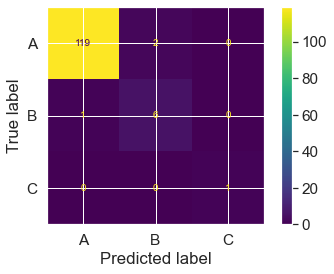

In [111]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test,y_pred)
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

#### The statistics obtained from the confusion matrix for the multiclass problem are calculated as follows:
- Precision = TP/(TP+FP)
- Recall = TP(TP+FN)

<img width="50%" height="50%" align="left" src="confusionmatrix2.png"> 


In [112]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           A       0.99      0.98      0.99       121
           B       0.75      0.86      0.80         7
           C       1.00      1.00      1.00         1

    accuracy                           0.98       129
   macro avg       0.91      0.95      0.93       129
weighted avg       0.98      0.98      0.98       129



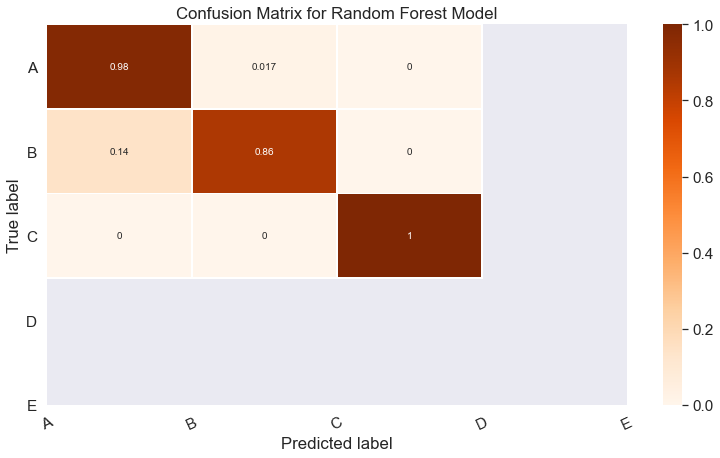

In [113]:
# Visualizing the confusion matrix with percentages
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Oranges, linewidths=0.2)

# Add labels to the plot
class_names = ['A','B', 'C', 'D', 'E']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

#### Log Loss 

In [114]:
from sklearn.metrics import log_loss

clf_probs = classifier.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)

score = log_loss(y_test, clf_probs, labels=['A','B','C','D', 'E'])
cal_score = log_loss(y_test, cal_clf_probs, labels=['A','B','C','D', 'E'])

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 0.062
 * calibrated classifier: 0.094


According to this [resource](https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d), a relatively high log-loss (significantly larger than 0) is acceptable for the case of a multiclass problem. The present one can be considered as very solid.

#### Roc/Auc Score

In [115]:
roc_auc_score(y, cal_clf.predict_proba(X), multi_class='ovr')

0.5860870035019596

According to the available resources, an Roc/Auc score of 1 would be the best score. The present one is a little higher than the others.

#### Key conclusions. 

##### The results are solid. The category "A", that is, the one with the lowest size, is the one that tends to be more solidly predicted, with sound overall accuracy. It interesting to note that the inclusion of "class_weight='balanced'" has led to the unexpected prediction of a "C", which corresponds to a much higher size, with considerably high precision.